**Todo**
---
> 1. Make all the Conv Layers functions <-- did this
> 2. 2x2 inputs and 4x4 inputs <-- is finished ^
> 3. Adam Optimizer <-- not important right now
> 4. 1.6 in tutorial <-- is finished
> 5. 1.7 in tutorial <-- Saturday

**Installation of Necessary Modules**
1.   Tensorflow==2.4.1
2.   Tensorflow-Quantum
3.   Sympy
4.   Numpy
5.   Google Cirq
6.   Pennylane (Just in Case)



In [ ]:
!pip install -q tensorflow==2.4.1 tensorflow-quantum
!pip install cirq sympy numpy pennylane

**Importing Modules**


1.   Matplotlib.pyplot as plt
2.   SVGCircuit from Cirq.contrib.svg
3.   Tensorflow as tf and Tensorflow_Quantum as tfq
4.   Google Cirq for writing the circuit
5.   Sympy as sp
6.   Numpy as np from Pennylane
7.   Pennylane as qml
8.   Itertools for efficient iteration
9.   Math for doing math



In [5]:
#%tb #full traceback for errors
%matplotlib inline
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
import cirq
from cirq.contrib.svg import SVGCircuit
import sympy as sp
import pennylane
from pennylane import numpy as np
from math import *
from itertools import *

**Abhik's Section**

In [3]:
#Can put code here

**Function which Creates the Circuit and Qubits**

In [6]:
numOfQubits = 4

In [7]:
def createCircuit(num_qubits):
    qubits = cirq.GridQubit.rect(1, num_qubits)
    circuit = cirq.Circuit()
    return qubits, circuit

In [8]:
qubits, vqc = createCircuit(numOfQubits)

*If you mess up run the "I messed up function"*


In [ ]:
#I messed up function
#qubits, vqc = createCircuit(4)

**Cluster State PQC**
1. Hadamard all Qubit
2. CNOT each pair of qubits (0,1), (1,2) (2,3), (3,0)

In [9]:
def Cluster_State_PQC(bits):
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

**Rotation Angle Initialization before perfoming Convolution and Pooling and Gate Functions**

In [10]:
def InitRot(numOfAngles=74, angle = np.pi/2):
    return np.array([angle for i in range(numOfAngles)])

In [11]:
default = InitRot()
print(default)

[1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633]


*Rotation angles subject to changes at any time*

In [12]:
def U3_Gate(bit, params):
    return cirq.Circuit(
        cirq.X(bit)**params[0],
        cirq.Y(bit)**params[1],
        cirq.Z(bit)**params[2])

In [13]:
def CU_Gate(other_bit, bit, params):
    return cirq.Circuit(
        cirq.X(bit).controlled_by(other_bit)**params[0],
        cirq.Y(bit).controlled_by(other_bit)**params[1],
        cirq.Z(bit).controlled_by(other_bit)**params[2])

**Quantum Convolution Layer 1**.  
*Consists of RY gates with fixed angle of rotation (non-trainable) and CNOT pattern as in the PQC* 

In [16]:
def QConvLayer1(qubits): 
    circuit = cirq.Circuit()
    for first in qubits:
        circuit.append(cirq.Ry(rads=np.pi)(first))
    for first, second in zip(qubits[0::1], qubits[1::1] + [qubits[0]]):
        circuit.append(cirq.CNOT(first, second))
    return circuit

**Quantum Convolution Layer 2**  
*Consists of U3 gates applied to each qubit and CU gates applied in the CNOT pattern*

In [17]:
def QConvLayer2(qubits, params):
    circuit = cirq.Circuit()
    index = 0
    for qubit in qubits:
        circuit += U3_Gate(qubit, params[index : index+3])
        index += 3
    for first, second in zip(qubits[0::1], qubits[1::1] + [qubits[0]]):
        circuit += CU_Gate(first, second, params[index : index+3])
        index += 3
    return circuit

**Quantum Convolution Layer 3**

In [19]:
def QConvLayer3(qubits, params):
    circuit = cirq.Circuit()
    index=0
    for qubit in qubits:
        circuit += U3_Gate(qubit, params[index : index+3])
        index += 3
    circuit += cirq.CNOT(control=qubits[0], target=qubits[1])
    circuit += (cirq.CNOT(control=qubits[3], target=qubits[2]))
    circuit += U3_Gate(qubits[0], [np.pi, np.pi, np.pi])
    circuit += U3_Gate(qubits[3], [np.pi/2, np.pi/2, np.pi/2])
    circuit += cirq.CNOT(control=qubits[0], target=qubits[1])
    circuit += cirq.CNOT(control=qubits[3], target=qubits[2])
    return circuit

**Quantum Convolution Layer 4**

In [20]:
def QConvLayer4(qubits, params):
    circuit = cirq.Circuit()
    index = 0
    circuit += U3_Gate(qubits[0], params[0:3])
    for first, second in zip(qubits[0::1], qubits[1::1] + [qubits[0]]):
        circuit += cirq.CNOT(control=first, target=second)
        circuit += CU_Gate(first, second, params[index:index+3])
        index += 3
    return circuit

**Quantum Convolution Layer 5**

In [21]:
def QConvLayer5(qubits, params):
    circuit = cirq.Circuit()
    circuit += U3_Gate(qubits[0], params[0:3])
    circuit += cirq.CNOT(control=qubits[0], target=qubits[1])
    circuit += cirq.CNOT(control=qubits[2], target=qubits[3])
    circuit += U3_Gate(qubits[2], params[3:6])
    circuit += cirq.CNOT(control = qubits[2], target=qubits[1])
    circuit += U3_Gate(qubits[1], params[6:9])
    return circuit

**Quantum Convolution Layer 6**  
*Same as Layer 4 but CU is CNOT*

In [22]:
def QConvLayer6(qubits):
    circuit = cirq.Circuit()
    for i in range(1, len(qubits)):
        circuit += cirq.CNOT(qubits[0], qubits[i])
    circuit += U3_Gate(qubits[3], [np.pi, np.pi/2, np.pi/4])
    return circuit

**Quantum Pooling Layer**  

In [14]:
def QPoolLayer(source, sink, params):
    poolCircuit = cirq.Circuit()
    sinkBasisSelector = U3_Gate(sink, params[0:3])
    sourceBasisSelector = U3_Gate(source, params[3:6])
    poolCircuit.append(sinkBasisSelector)
    poolCircuit.append(sourceBasisSelector)
    poolCircuit.append(cirq.CNOT(control=source, target=sink))
    poolCircuit.append(sinkBasisSelector**-1)
    return poolCircuit

**1.6 Create Model**

In [25]:
def createModelCircuit(qubits, symbols=sp.symbols('param0:74')):
    modelCircuit = cirq.Circuit()
    modelCircuit += QConvLayer1(qubits)
    modelCircuit += QConvLayer2(qubits, symbols[0:24])
    modelCircuit += QConvLayer3(qubits, symbols[24:36])
    modelCircuit += QPoolLayer(qubits[0], qubits[2], symbols[36:42])
    modelCircuit += QConvLayer4(qubits, symbols[42:57])
    modelCircuit += QConvLayer5(qubits, symbols[57:67])
    modelCircuit += QPoolLayer(qubits[1], qubits[3], symbols[67:74])
    modelCircuit += QConvLayer6(qubits)
    return modelCircuit

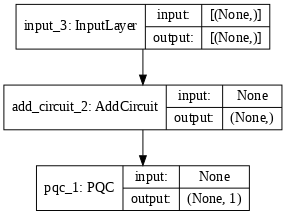

In [26]:
clusterStateBits = cirq.GridQubit.rect(1, 4)
readoutOps = cirq.Z(clusterStateBits[-1])
excitationInput = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
clusterState = tfq.layers.AddCircuit()(excitationInput, prepend=Cluster_State_PQC(clusterStateBits))
QModel = tfq.layers.PQC(createModelCircuit(clusterStateBits), readoutOps)(clusterState)
QCNNModel = tf.keras.Model(inputs=[excitationInput], outputs=[QModel])
tf.keras.utils.plot_model(QCNNModel, show_shapes=True, show_layer_names=True, dpi=70)